#BT5240 Course-Project - Stochastic Simulation Algorithm

Contributors:
*   Rajagopal Subramaniam C (BE20B026)
*   Dhananjay Balakrishnan (ME19B012)

#Initial Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import scipy

In [ ]:
np.random.seed(42)

In [ ]:
class simplified_lac_operon:

  def __init__(self, rates):
    #we initialize the rates
    self.rates = rates

  def query_lac_operon(self, values, reaction_id):
    if reaction_id == 0:
      if values['lactose'] >= 1 and values['repressor_active'] >= 1:
        values['lactose'] = values['lactose'] - 1
        values['repressor_active'] = values['repressor_active'] - 1

    elif reaction_id == 1:
      values['lactose'] = values['lactose'] + 1
      values['repressor_active'] = min(values['repressor_active'] + 1,values['repressor_total'])

    elif reaction_id == 2:
      if values['repressor_active'] >= 1 and values['operator_free'] >= 1:
        values['repressor_active'] = values['repressor_active'] - 1
        values['operator_free'] = values['operator_free'] - 1

    elif reaction_id == 3:
      values['repressor_active'] = min(values['repressor_active'] + 1, values['repressor_total'])
      values['operator_free'] = min(values['operator_free'] + 1, values['operator_total'])

    elif reaction_id == 4:
      values['mRNA'] = values['mRNA'] + 1

    elif reaction_id == 5:
      values['protein'] = values['protein'] + 1

    elif reaction_id == 6:
      values['mRNA'] = max(values['mRNA'] - 1, 0)

    elif reaction_id == 7:
      values['protein'] = max(values['protein'] - 1, 0)

    elif reaction_id == 8:
      values['lactose'] = max(values['lactose'] - 1, 0)

    else:
      values['lactose'] = values['lactose'] + 1

    return values

  def get_kinetics(self, values):
    kinetics = [self.rates['lactose_binding'] * values['lactose'] * values['repressor_active'],
         self.rates['lactose_unbinding'] * (values['repressor_total'] - values['repressor_active']),
         self.rates['repressor_binding'] * values['repressor_active'] * values['operator_free'],
         self.rates['repressor_unbinding'] * (values['operator_total'] - values['operator_free']),
         self.rates['transcription'] * values['operator_free'],
         self.rates['translation'] * values['mRNA'],
         self.rates['mRNA_degradation'] * values['mRNA'],
         self.rates['protein_degradation'] * values['protein'],
         self.rates['metabolize_lactose'] * values['protein'] * values['lactose'],
         self.rates['enter_lactose'] * values['lactose']]

    return kinetics


In [ ]:
values_initial = {
    'lactose':20,
    'repressor_active':10,
    'repressor_total':10,
    'operator_free':0,
    'operator_total':10,
    'mRNA':0,
    'protein':0
}

In [ ]:
rates = {
    'lactose_binding':0.1,
    'lactose_unbinding':0.1,
    'repressor_binding':0.05,
    'repressor_unbinding':0.05,
    'transcription':0.2,
    'translation':0.1,
    'mRNA_degradation':0.2,
    'protein_degradation':0.01,
    'metabolize_lactose':0.01,
    'enter_lactose':0.01
}

#Gillespie Algorithm (Vanilla)

In [ ]:
operon_model = simplified_lac_operon(rates)
n_sim = 2000
n_steps_trajectory = 1000
reaction_indices = np.arange(10)

In [ ]:
mc_simulations = []

for i in range(n_sim):
  if (i+1)%500 == 0:
    print(f'{i+1}/{n_sim} simulations completed...')

  time = 0
  values = copy.copy(values_initial)
  trajectories = [[0, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']]]

  for t_step in range(n_steps_trajectory):
    kinetics = operon_model.get_kinetics(values)
    R = sum(kinetics)
    if R == 0:
      print('Steady State Attained')
      break

    #calculating time taken for next reaction (poisson RV)
    u1 = np.random.random()
    time = time + 1/R * np.log(1/u1)

    #choosing a reaction out of the possible ones randomly
    pvec = 1/R*np.array(kinetics)
    reaction_index = np.random.choice(reaction_indices, p = pvec)
    values_next =  operon_model.query_lac_operon(values, reaction_index)

    values = copy.copy(values_next)
    trajectories.append([time, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']])


  mc_simulations.append(trajectories)

500/2000 simulations completed...
1000/2000 simulations completed...
1500/2000 simulations completed...
2000/2000 simulations completed...


In [ ]:
mc_simulations = np.array(mc_simulations)
print(np.shape(mc_simulations))

(2000, 1001, 6)


In [ ]:
t_max = mc_simulations[:, :, 0].max()
tvec_av = np.linspace(0, t_max, n_steps_trajectory + 1)

In [ ]:
lactose_vanilla = np.mean(mc_simulations[:, :, 1], axis = 0)
repressor_active_vanilla = np.mean(mc_simulations[:, :, 2], axis = 0)
operator_free_vanilla = np.mean(mc_simulations[:, :, 3], axis = 0)
mRNA_vanilla = np.mean(mc_simulations[:, :, 4], axis = 0)
protein_vanilla = np.mean(mc_simulations[:, :, 5], axis = 0)

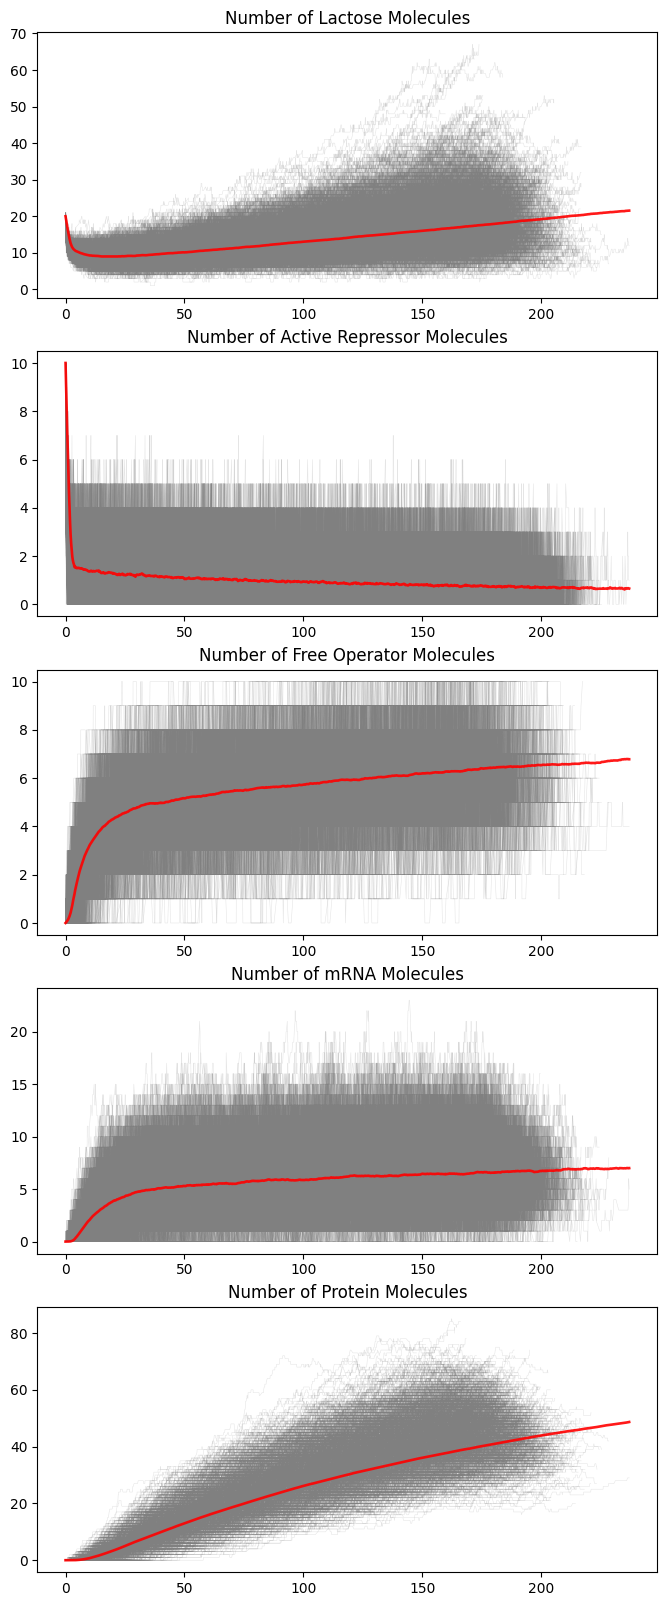

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))


for i in range(n_sim):
    axs[0].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 1], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[1].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 2], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[2].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 3], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[3].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[4].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 5], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs[0].plot(tvec_av, lactose_vanilla, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec_av, repressor_active_vanilla, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec_av, operator_free_vanilla, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec_av, mRNA_vanilla, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec_av, protein_vanilla, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[4].set_title('Number of Protein Molecules')

plt.show()


In [ ]:
def get_pdf_values(observations):
  n = 1000
  delta_x = (max(observations)-min(observations))/n
  cdf_values = np.zeros([n, 1])
  cdf_bins = np.linspace(min(observations), max(observations), n)
  for i in range(n):
    cdf_values[i] = np.sum(observations < cdf_bins[i])/len(observations)

  pdf_values = np.zeros([n-1, 1])
  for i in range(n-1):
    pdf_values[i] = (cdf_values[i+1] - cdf_values[i])/delta_x

  return cdf_bins[:-1], cdf_values[:-1], pdf_values

def plot_pdf(observations, reactant = 'None'):
  bins, cdf_values, pdf_values = get_pdf_values(observations)
  fig, ax1 = plt.subplots()
  ax1.plot(bins, cdf_values, color='red', label = 'cdf')
  ax1.set_ylabel('CDF values')
  ax2 = ax1.twinx()
  ax2.plot(bins, pdf_values, color = 'blue', label = 'pdf')
  ax2.set_ylabel('PDF values')

  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()

  # Combine handles and labels from both axes
  handles = handles1 + handles2
  labels = labels1 + labels2

  # Display the combined legend
  plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1.15))
  plt.title(f'Probability Distribution of {reactant} at the last timestep')

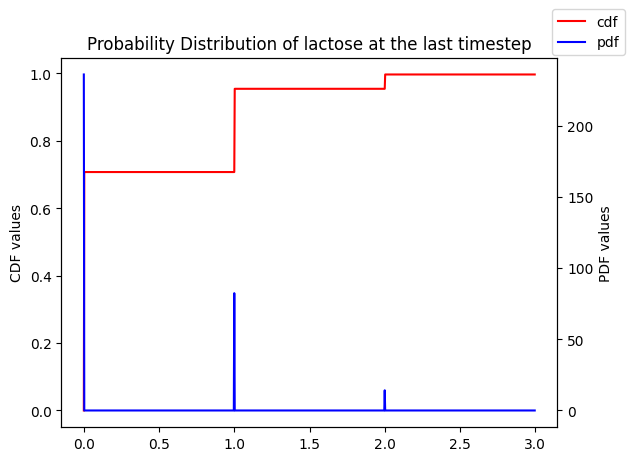

In [ ]:
plot_pdf(mc_simulations[:, n_steps_trajectory, 1], 'lactose')

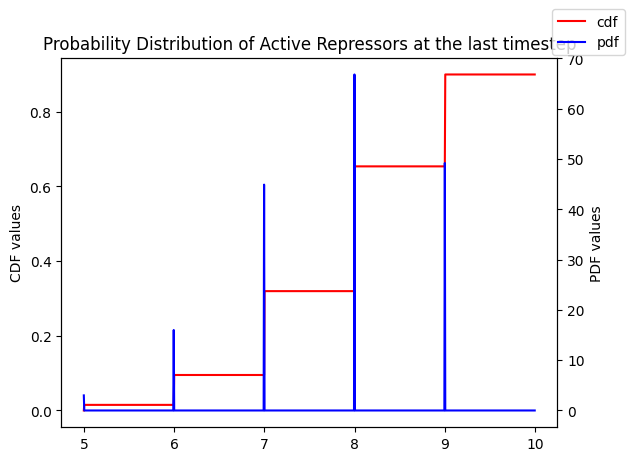

In [ ]:
plot_pdf(mc_simulations[:, n_steps_trajectory, 2], 'Active Repressors')

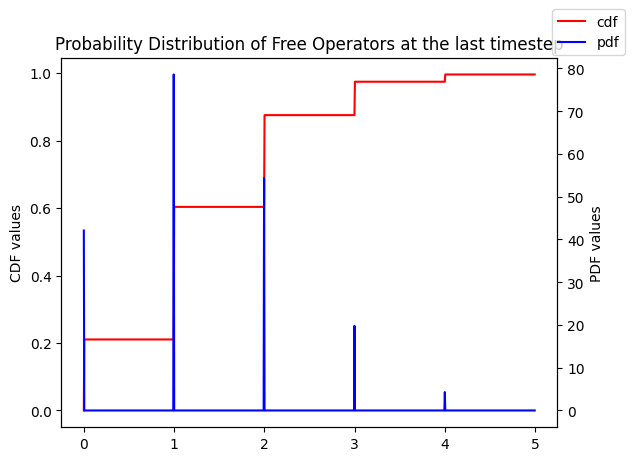

In [ ]:
plot_pdf(mc_simulations[:, n_steps_trajectory, 3], 'Free Operators')

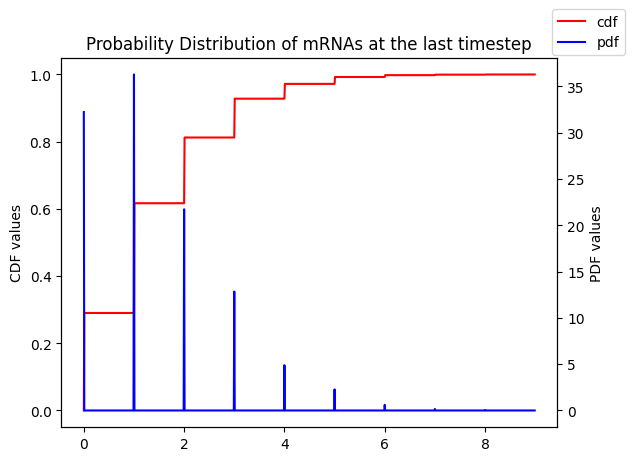

In [ ]:
plot_pdf(mc_simulations[:, n_steps_trajectory, 4], 'mRNAs')

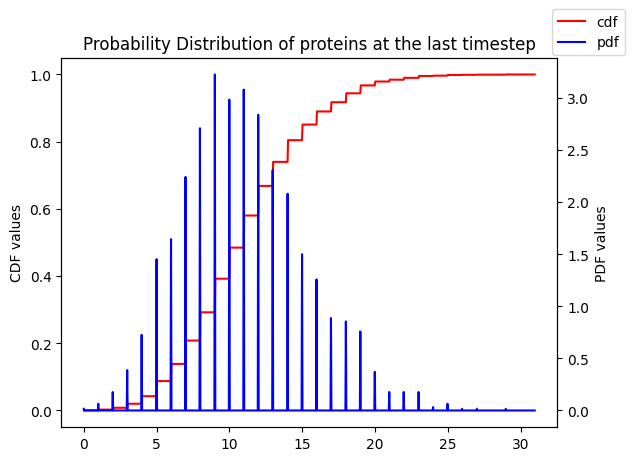

In [ ]:
plot_pdf(mc_simulations[:, n_steps_trajectory, 5], 'proteins')

In [ ]:
bins, cdf_values, pdf_values = get_pdf_values(mc_simulations[:, n_steps_trajectory, 5])
f = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)
y_values = [y[0] for y in cdf_values]
mu,sigma = scipy.optimize.curve_fit(f,bins,y_values)[0]
print(mu, sigma)

10.84077233522776 4.221751459251934


Text(0, 0.5, 'Cumulative Probability')

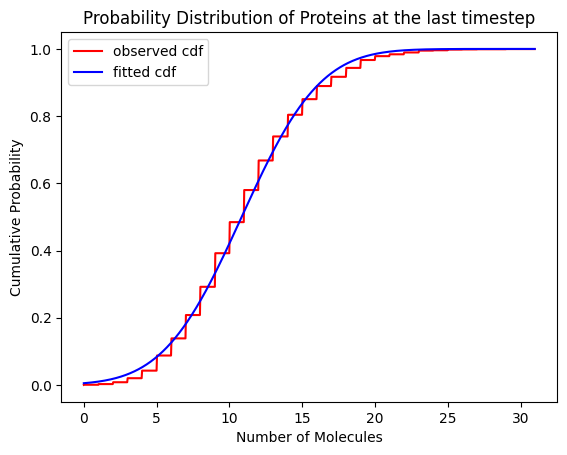

In [ ]:
theoretical_values = scipy.stats.norm.cdf(bins, loc=mu, scale=sigma)

fig, axs = plt.subplots()
axs.plot(bins, y_values, color='red', label = 'observed cdf')
axs.plot(bins, theoretical_values, color = 'blue', label = 'fitted cdf')
axs.legend()
axs.set_title('Probability Distribution of Proteins at the last timestep')
axs.set_xlabel('Number of Molecules')
axs.set_ylabel('Cumulative Probability')

# Tau-Leaping


In [ ]:
from scipy.stats import poisson

In [ ]:
operon_model = simplified_lac_operon(rates)
n_sim = 500
n_steps_trajectory = 500
reaction_indices = np.arange(10)
delta_t = t_max/n_steps_trajectory

In [ ]:
def get_number_of_reactions(kinetics, delta_t):
  n = len(kinetics)
  probabilities = np.random.uniform(0, 1, n)
  n_reactions = []

  for i in range(0, n):
    num = poisson.ppf(probabilities[i], kinetics[i]*delta_t)
    n_reactions.append(int(num))

  return n_reactions

In [ ]:
mc_simulations = []

tvec = np.arange(0, t_max, delta_t)

for i in range(n_sim):
  if (i+1)%100 == 0:
    print(f'{i+1}/{n_sim} simulations completed...')

  time = 0
  values = copy.copy(values_initial)
  trajectories = [[values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']]]

  for time in tvec:
    kinetics = operon_model.get_kinetics(values)
    R = sum(kinetics)
    if R == 0:
      print('Steady State Attained')
      break

    #get the number of reactions of each time that would have taken place in a time step of delta_t
    n_reactions_vec = get_number_of_reactions(kinetics, delta_t)

    for j in range(len(kinetics)):
      reaction_index = j
      n_reactions = n_reactions_vec[j]

      #for each reaction, we simulate the reaction the expected number of times
      for k in range(n_reactions):
        values_next =  operon_model.query_lac_operon(values, reaction_index)
        values = copy.copy(values_next)

    trajectories.append([values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']])

  mc_simulations.append(trajectories)

100/500 simulations completed...
200/500 simulations completed...
300/500 simulations completed...
400/500 simulations completed...
500/500 simulations completed...


In [ ]:
mc_simulations = np.array(mc_simulations)

In [ ]:
lactose_tau = np.mean(mc_simulations[:, :, 0], axis = 0)
repressor_active_tau = np.mean(mc_simulations[:, :, 1], axis = 0)
operator_free_tau = np.mean(mc_simulations[:, :, 2], axis = 0)
mRNA_tau = np.mean(mc_simulations[:, :, 3], axis = 0)
protein_tau = np.mean(mc_simulations[:, :, 4], axis = 0)

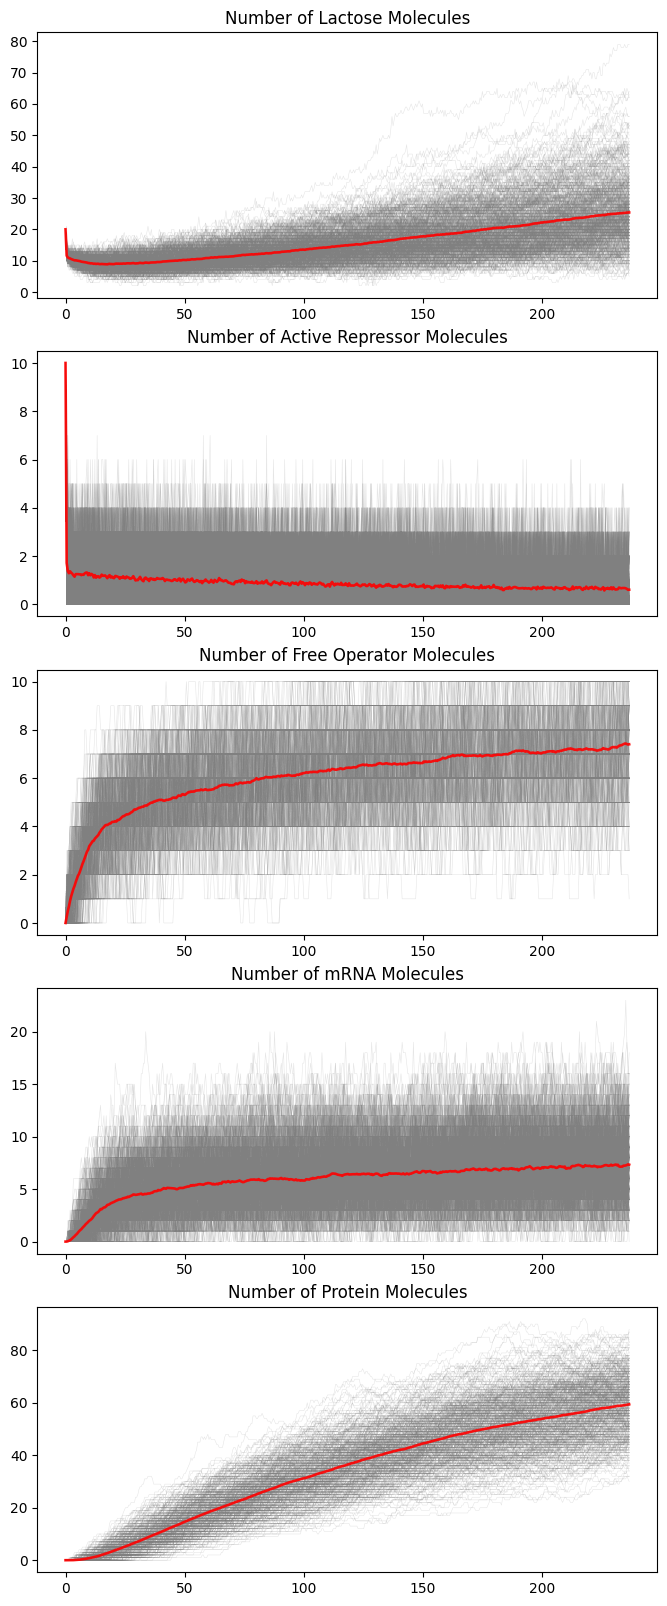

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))

for i in range(n_sim):
    axs[0].plot(tvec, mc_simulations[i, :-1, 0], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[1].plot(tvec, mc_simulations[i, :-1, 1], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[2].plot(tvec, mc_simulations[i, :-1, 2], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[3].plot(tvec, mc_simulations[i, :-1, 3], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[4].plot(tvec, mc_simulations[i, :-1, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs[0].plot(tvec, lactose_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec, repressor_active_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec, operator_free_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec, mRNA_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec, protein_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs[4].set_title('Number of Protein Molecules')

plt.show()

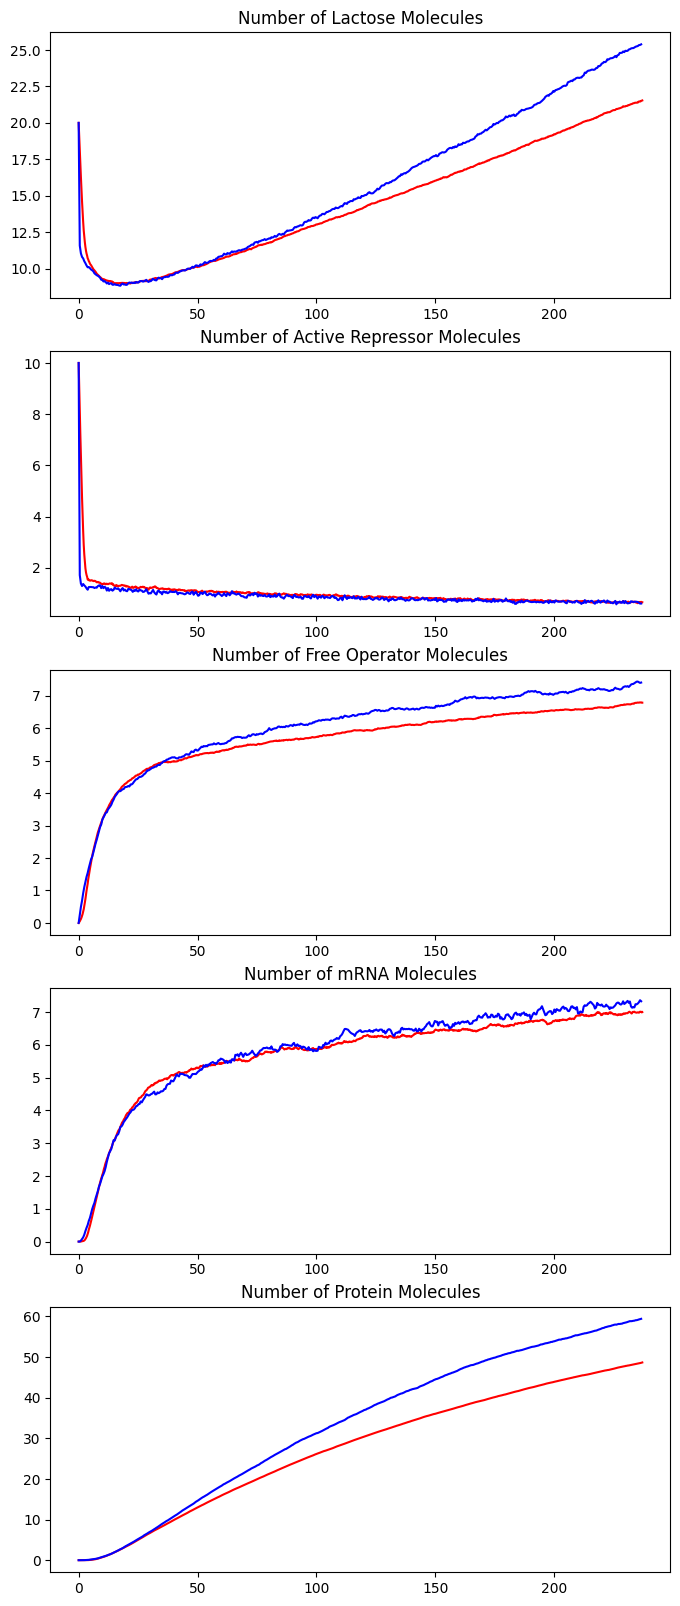

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))

axs[0].plot(tvec_av, lactose_vanilla, marker='', color='red', linewidth=1.5)
axs[0].plot(tvec, lactose_tau[:-1], marker='', color='blue', linewidth=1.5)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec_av, repressor_active_vanilla, marker='', color='red', linewidth=1.5)
axs[1].plot(tvec, repressor_active_tau[:-1], marker='', color='blue', linewidth=1.5)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec_av, operator_free_vanilla, marker='', color='red', linewidth=1.5)
axs[2].plot(tvec, operator_free_tau[:-1], marker='', color='blue', linewidth=1.5)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec_av, mRNA_vanilla, marker='', color='red', linewidth=1.5)
axs[3].plot(tvec, mRNA_tau[:-1], marker='', color='blue', linewidth=1.5)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec_av, protein_vanilla, marker='', color='red', linewidth=1.5)
axs[4].plot(tvec, protein_tau[:-1], marker='', color='blue', linewidth=1.5)
axs[4].set_title('Number of Protein Molecules')

plt.show()

Text(0, 0.5, 'Number of Protein Molecules')

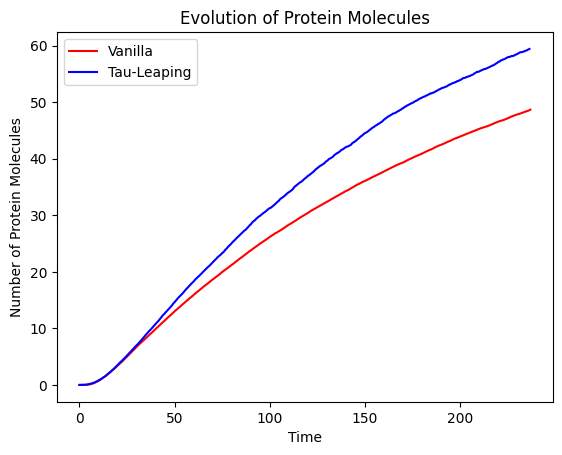

In [ ]:
fig, axs = plt.subplots()
axs.plot(tvec_av, protein_vanilla, marker='', color='red', linewidth=1.5)
axs.plot(tvec, protein_tau[:-1], marker='', color='blue', linewidth=1.5)
axs.set_title('Evolution of Protein Molecules')
axs.legend(['Vanilla', 'Tau-Leaping'])
axs.set_xlabel('Time')
axs.set_ylabel('Number of Protein Molecules')

Text(0, 0.5, 'Number of Protein Molecules')

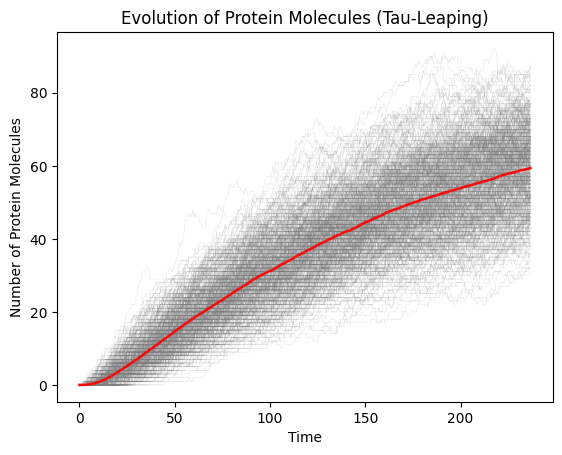

In [ ]:
fig, axs = plt.subplots()
for i in range(n_sim):
    axs.plot(tvec, mc_simulations[i, :-1, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs.plot(tvec, protein_tau[:-1], marker='', color='red', linewidth=1.9, alpha=0.9)
axs.set_title('Evolution of Protein Molecules (Tau-Leaping)')
axs.set_xlabel('Time')
axs.set_ylabel('Number of Protein Molecules')

#Ablation Studies

##Experiment-1 (Restricting mRNA production):

In [ ]:
rates = {
    'lactose_binding':0.1,
    'lactose_unbinding':0.1,
    'repressor_binding':0.05,
    'repressor_unbinding':0.05,
    'transcription':0.001, # reduce it if you want to prevent mRNA production
    'translation':0.1, # reduce it if you want to prevent protein production
    'mRNA_degradation':0.2,
    'protein_degradation':0.01,
    'metabolize_lactose':0.01, # if you prevent protein action of lactose
    'enter_lactose':0.01
}

In [ ]:
operon_model = simplified_lac_operon(rates)
n_sim = 2000
n_steps_trajectory = 1000
reaction_indices = np.arange(10)

In [ ]:
mc_simulations = []

for i in range(n_sim):
  if (i+1)%500 == 0:
    print(f'{i+1}/{n_sim} simulations completed...')

  time = 0
  values = copy.copy(values_initial)
  trajectories = [[0, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']]]

  for t_step in range(n_steps_trajectory):
    kinetics = operon_model.get_kinetics(values)
    R = sum(kinetics)
    if R == 0:
      print('Steady State Attained')
      break

    #calculating time taken for next reaction (poisson RV)
    u1 = np.random.random()
    time = time + 1/R * np.log(1/u1)

    #choosing a reaction out of the possible ones randomly
    pvec = 1/R*np.array(kinetics)
    reaction_index = np.random.choice(reaction_indices, p = pvec)
    values_next =  operon_model.query_lac_operon(values, reaction_index)

    values = copy.copy(values_next)
    trajectories.append([time, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']])


  mc_simulations.append(trajectories)

500/2000 simulations completed...
1000/2000 simulations completed...
1500/2000 simulations completed...
2000/2000 simulations completed...


In [ ]:
mc_simulations = np.array(mc_simulations)

In [ ]:
t_max = mc_simulations[:, :, 0].max()
tvec_av = np.linspace(0, t_max, n_steps_trajectory + 1)

In [ ]:
lactose_abl1 = np.mean(mc_simulations[:, :, 1], axis = 0)
repressor_active_abl1 = np.mean(mc_simulations[:, :, 2], axis = 0)
operator_free_abl1 = np.mean(mc_simulations[:, :, 3], axis = 0)
mRNA_abl1 = np.mean(mc_simulations[:, :, 4], axis = 0)
protein_abl1 = np.mean(mc_simulations[:, :, 5], axis = 0)

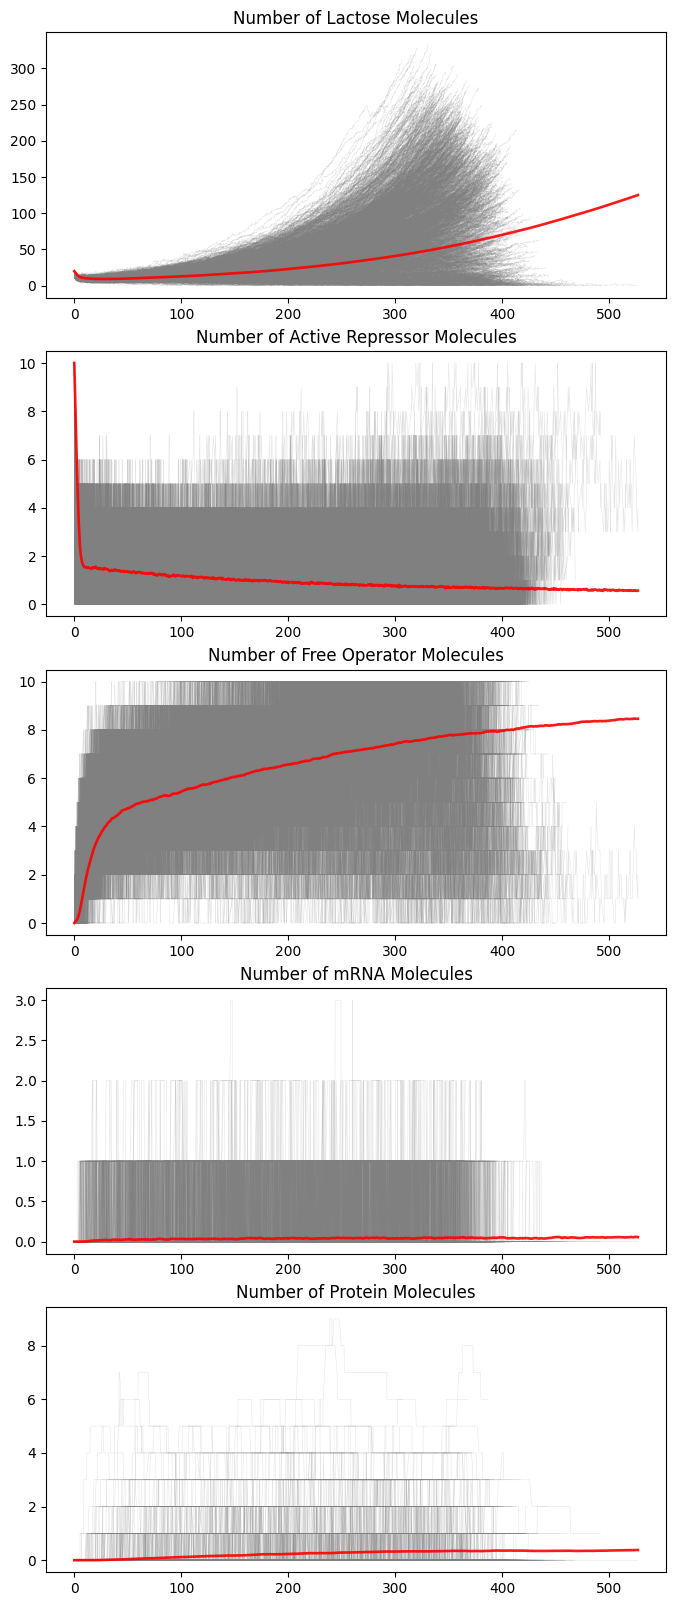

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))


for i in range(n_sim):
    axs[0].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 1], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[1].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 2], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[2].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 3], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[3].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[4].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 5], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs[0].plot(tvec_av, lactose_abl1, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec_av, repressor_active_abl1, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec_av, operator_free_abl1, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec_av, mRNA_abl1, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec_av, protein_abl1, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[4].set_title('Number of Protein Molecules')

plt.show()


#Experiment-2 (Restricting Protein Production):

In [ ]:
rates = {
    'lactose_binding':0.1,
    'lactose_unbinding':0.1,
    'repressor_binding':0.05,
    'repressor_unbinding':0.05,
    'transcription':0.2, # reduce it if you want to prevent mRNA production
    'translation':0.001, # reduce it if you want to prevent protein production
    'mRNA_degradation':0.2,
    'protein_degradation':0.01,
    'metabolize_lactose':0.01, # if you prevent protein action of lactose
    'enter_lactose':0.01
}

In [ ]:
operon_model = simplified_lac_operon(rates)
n_sim = 2000
n_steps_trajectory = 1000
reaction_indices = np.arange(10)

In [ ]:
mc_simulations = []

for i in range(n_sim):
  if (i+1)%500 == 0:
    print(f'{i+1}/{n_sim} simulations completed...')

  time = 0
  values = copy.copy(values_initial)
  trajectories = [[0, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']]]

  for t_step in range(n_steps_trajectory):
    kinetics = operon_model.get_kinetics(values)
    R = sum(kinetics)
    if R == 0:
      print('Steady State Attained')
      break

    #calculating time taken for next reaction (poisson RV)
    u1 = np.random.random()
    time = time + 1/R * np.log(1/u1)

    #choosing a reaction out of the possible ones randomly
    pvec = 1/R*np.array(kinetics)
    reaction_index = np.random.choice(reaction_indices, p = pvec)
    values_next =  operon_model.query_lac_operon(values, reaction_index)

    values = copy.copy(values_next)
    trajectories.append([time, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']])


  mc_simulations.append(trajectories)

500/2000 simulations completed...
1000/2000 simulations completed...
1500/2000 simulations completed...
2000/2000 simulations completed...


In [ ]:
mc_simulations = np.array(mc_simulations)

In [ ]:
t_max = mc_simulations[:, :, 0].max()
tvec_av = np.linspace(0, t_max, n_steps_trajectory + 1)

In [ ]:
lactose_abl2 = np.mean(mc_simulations[:, :, 1], axis = 0)
repressor_active_abl2 = np.mean(mc_simulations[:, :, 2], axis = 0)
operator_free_abl2 = np.mean(mc_simulations[:, :, 3], axis = 0)
mRNA_abl2 = np.mean(mc_simulations[:, :, 4], axis = 0)
protein_abl2 = np.mean(mc_simulations[:, :, 5], axis = 0)

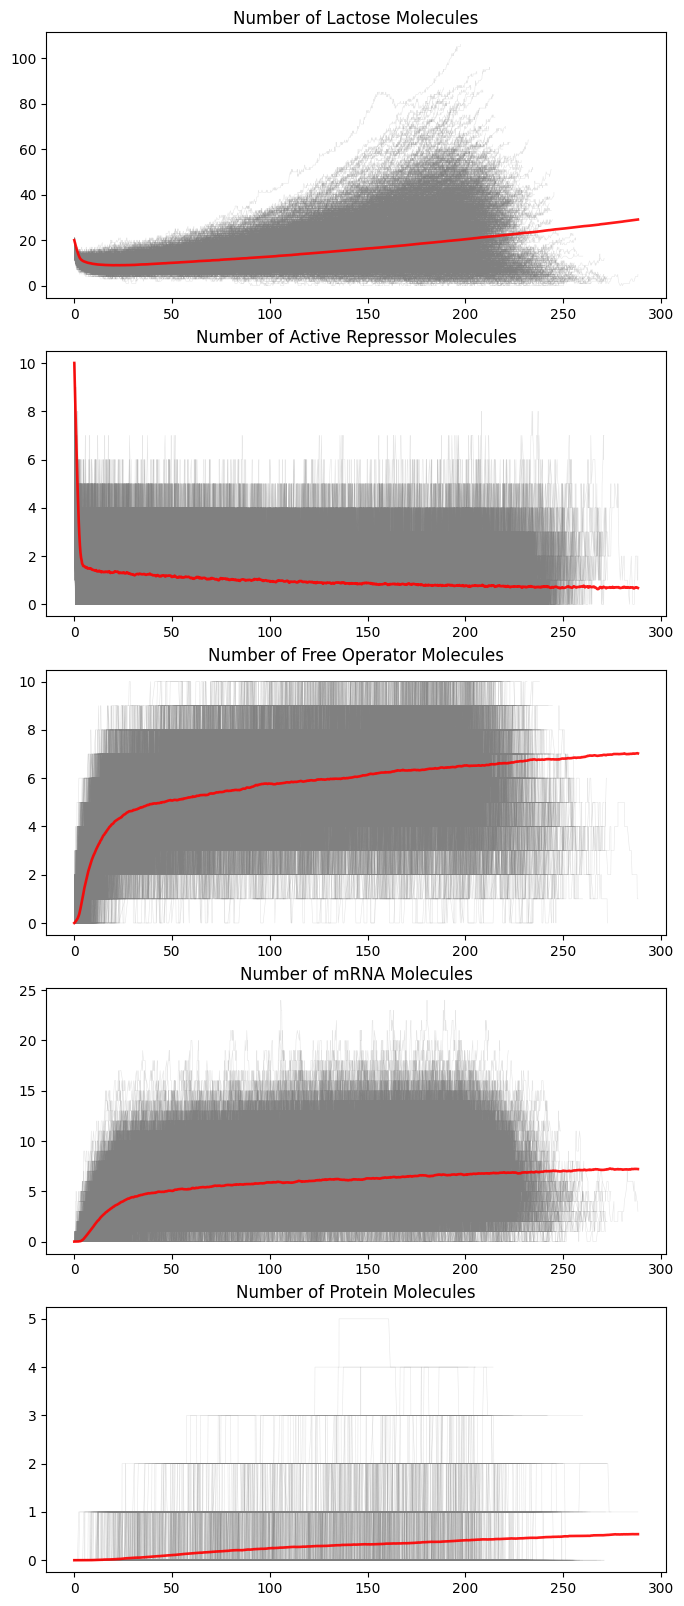

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))


for i in range(n_sim):
    axs[0].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 1], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[1].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 2], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[2].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 3], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[3].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[4].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 5], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs[0].plot(tvec_av, lactose_abl2, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec_av, repressor_active_abl2, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec_av, operator_free_abl2, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec_av, mRNA_abl2, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec_av, protein_abl2, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[4].set_title('Number of Protein Molecules')

plt.show()


#Experiment-3 (Restricting Protein action of Lactose):

In [ ]:
rates = {
    'lactose_binding':0.1,
    'lactose_unbinding':0.1,
    'repressor_binding':0.05,
    'repressor_unbinding':0.05,
    'transcription':0.2, # reduce it if you want to prevent mRNA production
    'translation':0.1, # reduce it if you want to prevent protein production
    'mRNA_degradation':0.2,
    'protein_degradation':0.01,
    'metabolize_lactose':0.0001, # if you prevent protein action of lactose
    'enter_lactose':0.01
}

In [ ]:
operon_model = simplified_lac_operon(rates)
n_sim = 2000
n_steps_trajectory = 1000
reaction_indices = np.arange(10)

In [ ]:
mc_simulations = []

for i in range(n_sim):
  if (i+1)%500 == 0:
    print(f'{i+1}/{n_sim} simulations completed...')

  time = 0
  values = copy.copy(values_initial)
  trajectories = [[0, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']]]

  for t_step in range(n_steps_trajectory):
    kinetics = operon_model.get_kinetics(values)
    R = sum(kinetics)
    if R == 0:
      print('Steady State Attained')
      break

    #calculating time taken for next reaction (poisson RV)
    u1 = np.random.random()
    time = time + 1/R * np.log(1/u1)

    #choosing a reaction out of the possible ones randomly
    pvec = 1/R*np.array(kinetics)
    reaction_index = np.random.choice(reaction_indices, p = pvec)
    values_next =  operon_model.query_lac_operon(values, reaction_index)

    values = copy.copy(values_next)
    trajectories.append([time, values['lactose'],values['repressor_active'],values['operator_free'],values['mRNA'],values['protein']])


  mc_simulations.append(trajectories)

500/2000 simulations completed...
1000/2000 simulations completed...
1500/2000 simulations completed...
2000/2000 simulations completed...


In [ ]:
mc_simulations = np.array(mc_simulations)

In [ ]:
t_max = mc_simulations[:, :, 0].max()
tvec_av = np.linspace(0, t_max, n_steps_trajectory + 1)

In [ ]:
lactose_abl3 = np.mean(mc_simulations[:, :, 1], axis = 0)
repressor_active_abl3 = np.mean(mc_simulations[:, :, 2], axis = 0)
operator_free_abl3 = np.mean(mc_simulations[:, :, 3], axis = 0)
mRNA_abl3 = np.mean(mc_simulations[:, :, 4], axis = 0)
protein_abl3 = np.mean(mc_simulations[:, :, 5], axis = 0)

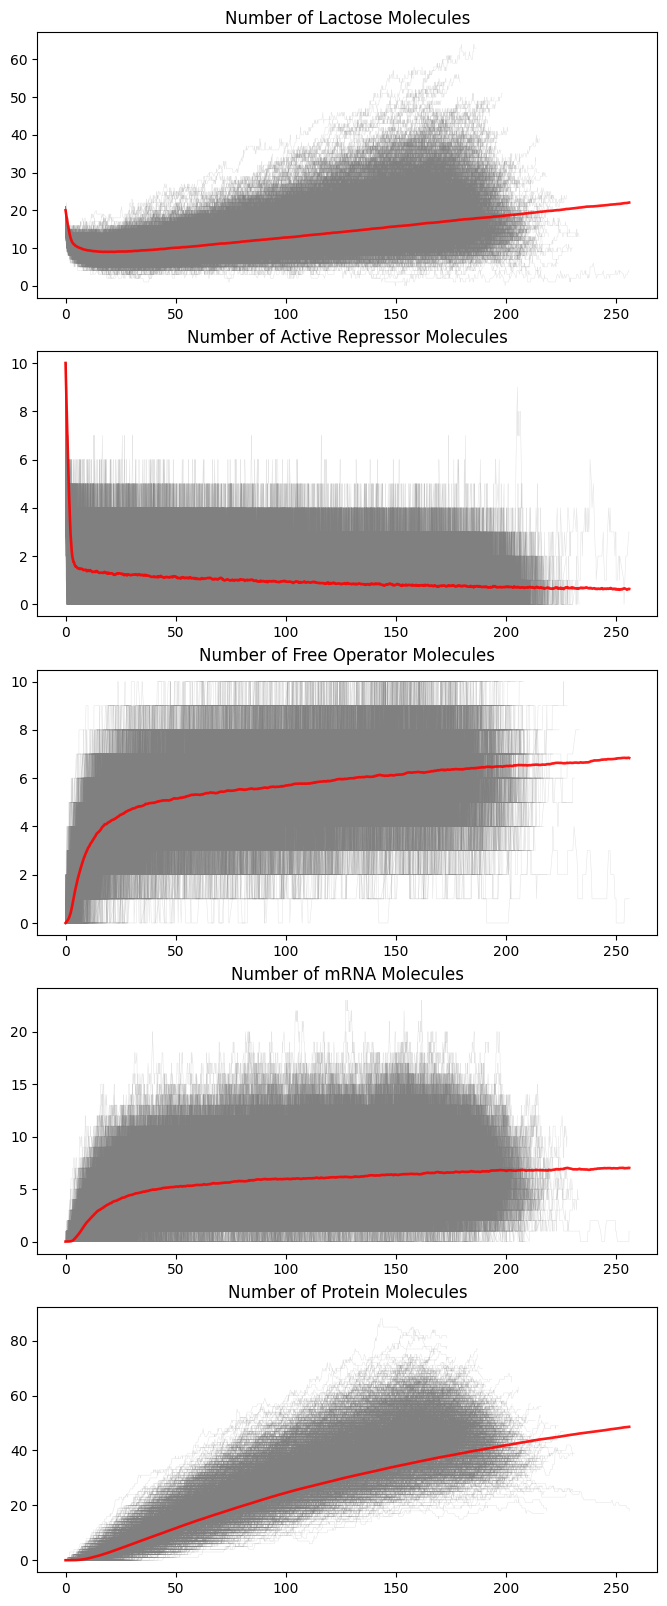

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8,20))


for i in range(n_sim):
    axs[0].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 1], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[1].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 2], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[2].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 3], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[3].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 4], marker='', color='grey', linewidth=0.4, alpha=0.2)
    axs[4].plot(mc_simulations[i, :, 0], mc_simulations[i, :, 5], marker='', color='grey', linewidth=0.4, alpha=0.2)

axs[0].plot(tvec_av, lactose_abl3, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Lactose Molecules')

axs[1].plot(tvec_av, repressor_active_abl3, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Active Repressor Molecules')

axs[2].plot(tvec_av, operator_free_abl3, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Free Operator Molecules')

axs[3].plot(tvec_av, mRNA_abl3, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[3].set_title('Number of mRNA Molecules')

axs[4].plot(tvec_av, protein_abl3, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[4].set_title('Number of Protein Molecules')

plt.show()
